In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

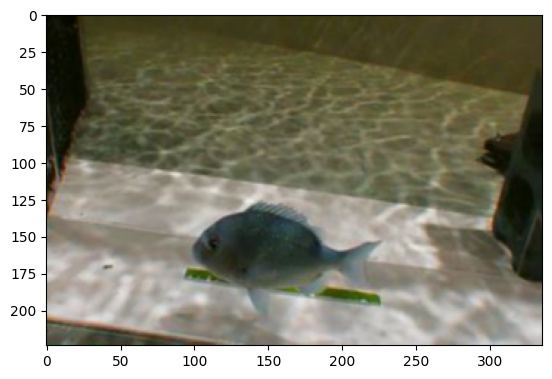

In [2]:
img = cv2.imread('./img/IMG2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

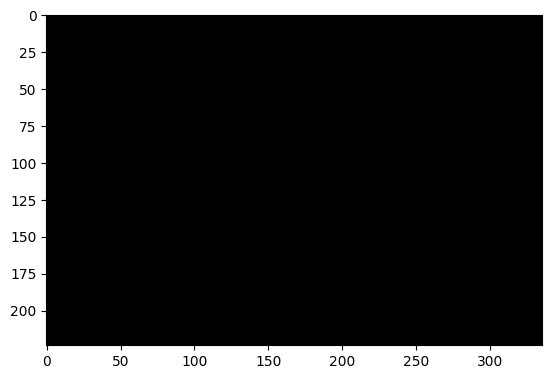

In [3]:
mask = np.zeros(img.shape[:2], dtype=np.uint8)
plt.imshow(mask, cmap='gray')

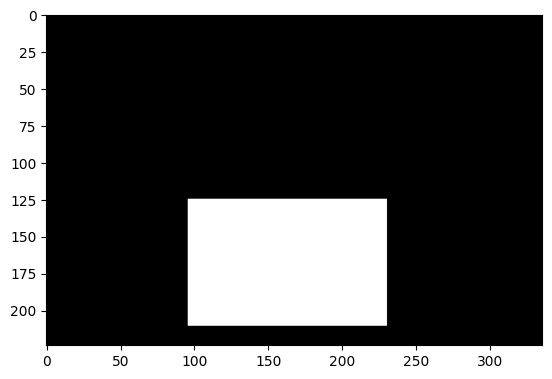

In [4]:
polly_points = np.array([(96,125), (230, 125), (230, 210), (96, 210)], dtype=np.int32)
cv2.fillPoly(mask, [polly_points], (255,2555,255))
plt.imshow(mask, cmap='gray')

True

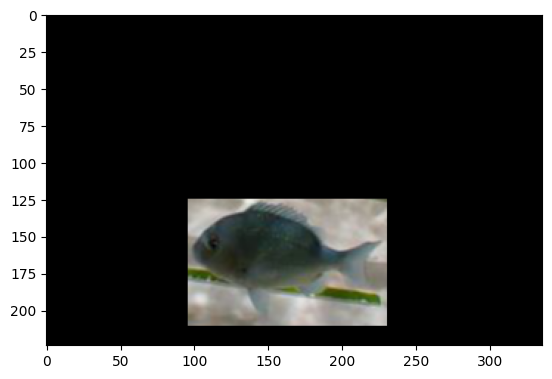

In [5]:
roi = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(roi, cmap='gray')
cv2.imwrite('./img/roi.png', roi)

In [6]:
img_r = roi.copy()
img_g = roi.copy()
img_b = roi.copy()

In [7]:
img_r = roi[:, :, 0]
img_g = roi[:, :, 1]
img_b = roi[:, :, 2]

In [8]:
img_rg = img_r - img_g
img_gb = img_g - img_b
img_br = img_b - img_r

In [9]:
img_rg[mask == 0] = 255
img_gb[mask == 0] = 255
img_br[mask == 0] = 255

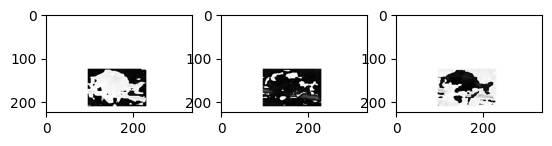

In [10]:
plt.subplot(1, 3, 1)
plt.imshow(img_rg, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(img_gb, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(img_br, cmap='gray')

In [11]:
cv2.imwrite('./img/img_rg.png', img_rg)
cv2.imwrite('./img/img_gb.png', img_gb)
cv2.imwrite('./img/img_br.png', img_br)

True

True

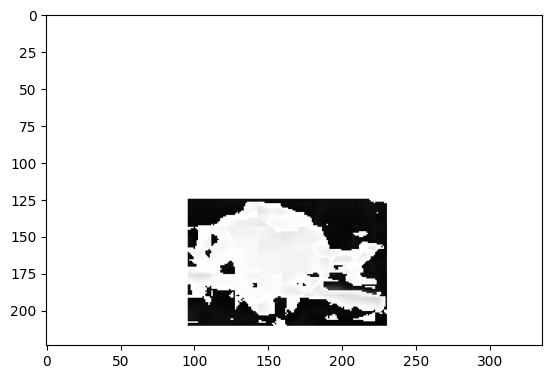

In [12]:
img_m = cv2.max(img_rg, img_gb, img_br)
plt.imshow(img_m, cmap='gray')
cv2.imwrite('./img/img_m.png', img_m)

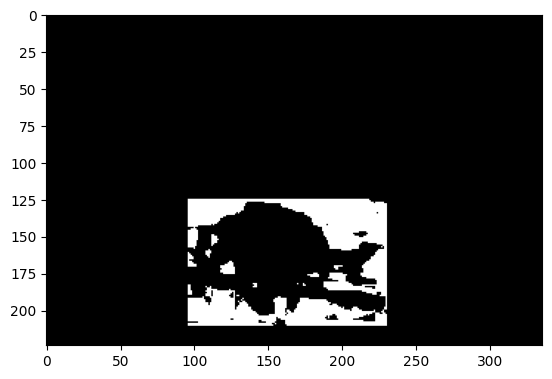

In [13]:
ret, thr = cv2.threshold(img_m, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt.imshow(thr, cmap='gray')

True

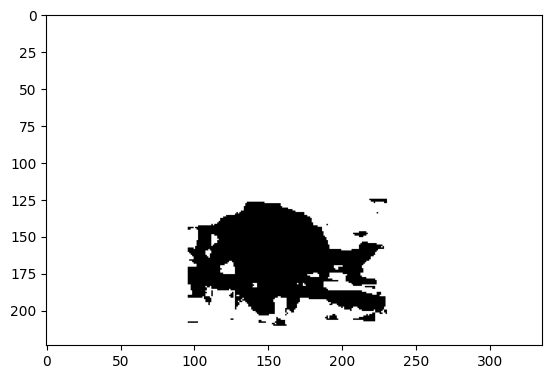

In [14]:
thr[mask == 0] = 255
plt.imshow(thr, cmap='gray')
cv2.imwrite('./img/thr.png', thr)

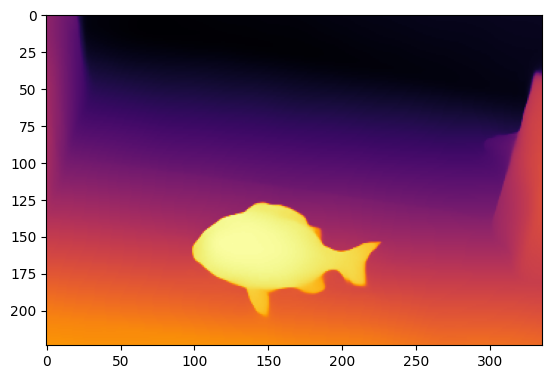

In [15]:
depth = cv2.imread('./depth/IMG2_depth.png')
depth = cv2.cvtColor(depth, cv2.COLOR_BGR2RGB)
plt.imshow(depth)

True

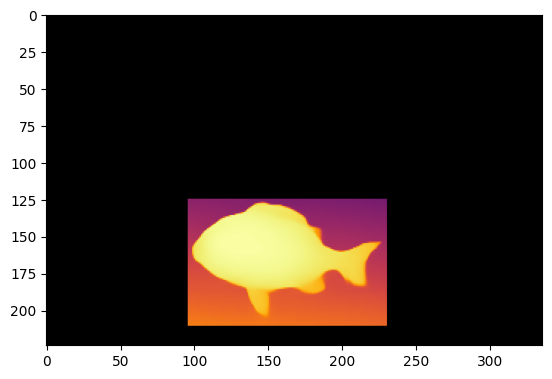

In [16]:
roi_depth = cv2.bitwise_and(depth, depth, mask=mask)
roi_depth_copy = roi_depth.copy()
plt.imshow(roi_depth, cmap='gray')
cv2.imwrite('./img/roi_depth.png', roi_depth_copy)

True

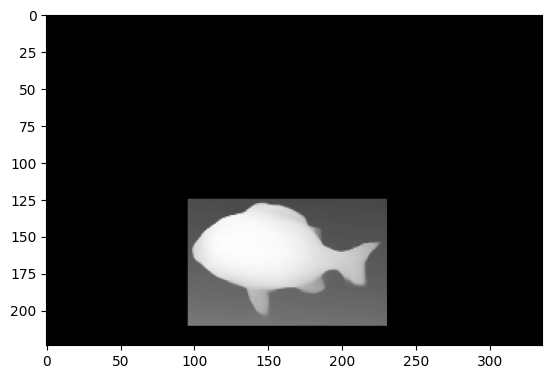

In [17]:
gray = cv2.cvtColor(roi_depth, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
cv2.imwrite('./img/gray.png', gray)

True

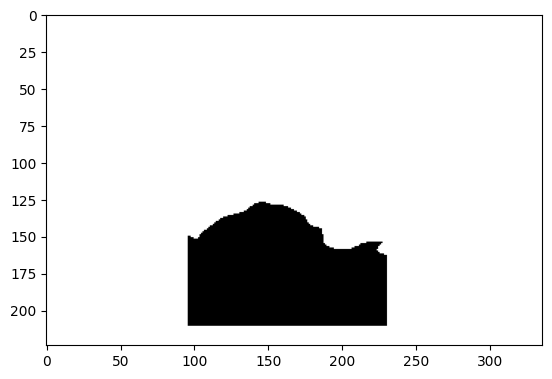

In [18]:
ret_depth, thr_depth = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt.imshow(thr_depth, cmap='gray')
cv2.imwrite('./img/thr_depth.png', thr_depth)

True

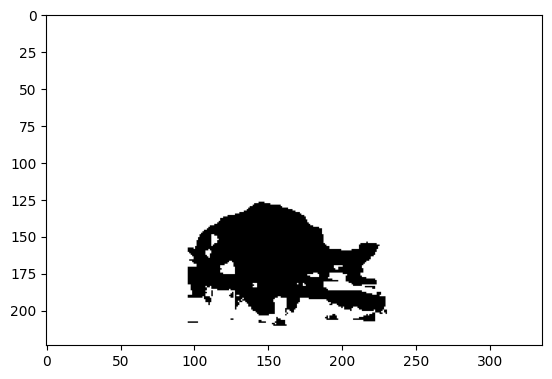

In [19]:
thr_m = cv2.max(thr, thr_depth)
plt.imshow(thr_m, cmap='gray')
cv2.imwrite('./img/thr_m.png', thr_m)

In [20]:
bbox_left = 96
bbox_top = 125
bbox_right = 230
bbox_bot = 210

In [21]:
COL = np.abs(bbox_top - bbox_bot)   
ROW = np.abs(bbox_right - bbox_left)
ITER0 = int(np.round((COL/100 + ROW/100) * np.minimum(ROW, COL) / np.maximum(ROW, COL)))
ITER0

1

In [22]:
ITER = int(np.round(np.minimum(COL, ROW)/10) * np.maximum(COL, ROW) / np.minimum(ROW, COL))
ITER = ITER0 + ITER
ITER

13

In [23]:
kernel1 = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=(3,3))
kernel2 = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=(5,5))
kernel3 = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=(7,7))

True

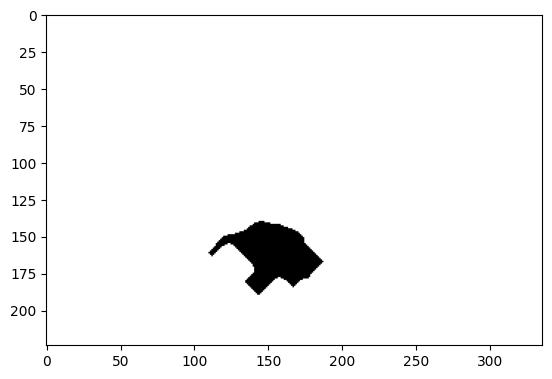

In [24]:
edged = cv2.morphologyEx(thr_m, cv2.MORPH_OPEN, kernel2, iterations=ITER0)
edged = cv2.dilate(edged, kernel1, iterations=ITER)
dilate = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel1, iterations=ITER0)
plt.imshow(dilate, cmap='gray')
cv2.imwrite('./img/dilate.png', dilate)

In [25]:
[col, row, ch] = img.shape

In [26]:
ITER2 = COL/10 + ROW/10
ITER2 = ITER2 * ((np.minimum(COL, ROW) / np.maximum(ROW, COL)))
ITER2 = int(np.round((ITER2 / (1 + ITER0)) * row / col))

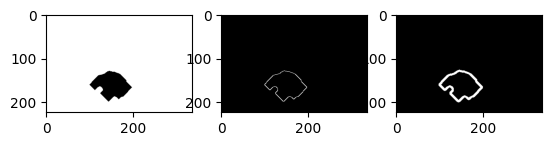

In [27]:
erode = cv2.erode(dilate, kernel1, iterations=ITER2)
plt.subplot(1,3,1)
plt.imshow(erode, cmap='gray')
cv2.imwrite('./img/erode.png', erode)

canny = cv2.Canny(erode, 50, 150)
plt.subplot(1,3,2)
plt.imshow(canny, cmap='gray')
cv2.imwrite('./img/canny.png', canny)

dilate = cv2.dilate(canny, kernel2, iterations=1)
plt.subplot(1,3,3)
plt.imshow(dilate, cmap='gray')

In [28]:
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [29]:
import imutils
from imutils import perspective
from imutils import contours
from scipy.spatial import distance as dist

In [30]:
cnts = cnts[0]
(cnts, _) = contours.sort_contours(cnts)

In [31]:
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

True

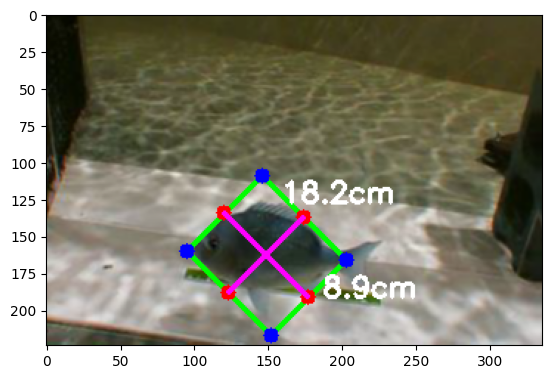

In [32]:
Ratio_row = col / 640
Ratio_col = row / 480

for index, c in enumerate(cnts):

    # if the contour is not sufficiently large, ignore it

    if cv2.contourArea(c) < 100:
       continue
    
	# compute the rotated bounding box of the contour
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")

    # order the points in the contour such that they appear
	# in top-left, top-right, bottom-right, and bottom-left
	# order, then draw the outline of the rotated bounding
	# box
    box = perspective.order_points(box)
    cv2.drawContours(img, [box.astype("int")], -1, (0, 255, 0), 2)

    # loop over the original points and draw them
    for (x, y) in box:
        cv2.circle(img, (int(x), int(y)), 5, (0, 0, 255), -1)

	# unpack the ordered bounding box, then compute the midpoint
	# between the top-left and top-right coordinates, followed by
	# the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)

    # compute the midpoint between the top-left and top-right points,
	# followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)

	# draw the midpoints on the image
    cv2.circle(img, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(img, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    cv2.circle(img, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    cv2.circle(img, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

	# draw lines between the midpoints
    cv2.line(img, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
		(255, 0, 255), 2)
    cv2.line(img, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
		(255, 0, 255), 2)

	# compute the Euclidean distance between the midpoints
    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
    
    dimA = dA  * 0.026458333 * Ratio_col
    dimB = dB  * 0.026458333 * Ratio_row
    
    cv2.putText(img, "18.2cm".format(dimA),    
		(int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
        
    cv2.putText(img, "8.9cm".format(dimB),    
		(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
plt.imshow(img)
cv2.imwrite('./img/predict.png', img)